In [227]:
import glob
import pickle
import numpy as np
import pandas as pd

$\textbf{Epidemiology: Clinical Model Results Aggregation}$

Organize model results into a table:

- __Window__ (i.e., max. number of days to use)
- __Epochs Trained__ (prior to stopping)
- __Validation Scores__ (Accuracy, F1, ROC AUC)

In [228]:
# unpack model results dictionary
def extract_model_results(
        results: dict,
        model_window: int = None,
) -> tuple:
    """
    Extracts model results from a dictionary and organizes them into two DataFrames:
    one for results by epoch and another for overall results.
    
    Args:
        results (dict): Dictionary containing model results.
        
    Returns:
        tuple: Two DataFrames, one for results by epoch and one for overall results.
    """
    # initialize dataframes
    results_by_epoch = pd.DataFrame()
    results_overall = pd.DataFrame()

    # iterate through dictionary items
    for key, value in results.items():
        if isinstance(value, list):
            results_by_epoch[key] = value
        else:
            results_overall[key] = [value]

    # add 'epoch' column
    results_by_epoch.insert(0, 'epoch', np.arange(len(results_by_epoch)))

    # add pk (model_window) if given
    if model_window is not None:
        results_overall.insert(0, 'model_window', model_window)
        results_by_epoch.insert(0, 'model_window', model_window)

    return results_by_epoch, results_overall


In [229]:
# get all model result files
model_result_files = glob.glob('storage/pitch_model_*')

# iterate through each file and load the results
results = {}
for file in model_result_files:
    with open(file, 'rb') as f:
        model_results = pickle.load(f)
    
    # get the day from the filename
    day = int(file.split('_')[-2].split('d')[0])
    results[day] = {}

    # extract results by epoch and overall results
    results_by_epoch, results_overall = extract_model_results(model_results, model_window=day)

    # add other performance metrics to overall results
        # .iloc[-6] since early stopping is set to 5 epochs before the end
    results_overall['best_val_acc'] = results_by_epoch.iloc[-6]['val_acc']
    results_overall['best_roc_auc'] = results_by_epoch.iloc[-6]['val_auc']
    results_overall['best_f1_score'] = results_by_epoch.iloc[-6]['val_f1']
    
    # store the results in the dictionary
    results[day]['by_epoch'] = results_by_epoch
    results[day]['overall'] = results_overall

In [230]:
# concatenate all results into a single DataFrame
all_results_by_epoch = pd.concat([results[day]['by_epoch'] for day in sorted(results.keys())], ignore_index=True)
all_results_overall = pd.concat([results[day]['overall'] for day in sorted(results.keys())], ignore_index=True)

$\textbf{Run Model Examples}$

Use validation set to visualize model outputs, features.

In [231]:
import torch
from nnet import CNNbiLSTM
from services.scalers import compute_masked_scalers, apply_scalers

In [232]:
# load model w/ path 
def load_model(
        model_skeleton: any,
        model_path: str
        ) -> CNNbiLSTM:
    """
    Loads a CNNbiLSTM model from a specified path.
    
    Args:
        model_skeleton (any): An instance of the nnet model class to load.
        model_path (str): Path to the model file.
        
    Returns:
        CNNbiLSTM: Loaded model instance.
    """
    # load the model state dictionary
    state_dict = torch.load(model_path)
    model_skeleton.load_state_dict(state_dict)
    
    # set the model to evaluation mode
    model_skeleton.eval()

    return model_skeleton


In [268]:
# load all model files
models = {}
for day in sorted(results.keys()):
    model_path = f'models/inj/pitch_model_{day}d_state_dict.pt'
    models[day] = load_model(CNNbiLSTM(k_in=9), model_path)

In [234]:
# load pitch-level tensors for validation
    # NOTE: these are preprocessed & scaled; scaler params not yet saved
    # TODO: will need to load the unscaled tensors to visualize features
model_val_data = {}
for day in sorted(results.keys()):
    with open(f'models/data/pitch_model_{day}d_val_data.pkl', 'rb') as f:
        model_val_data[day] = pickle.load(f)

In [293]:
model_val_data[7]['y_binary'].mean(dim=1)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1466, 0.0000, 0.0316, 0.1437, 0.0776, 0.2241, 0.2011, 0.0747, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0920, 0.1638, 0.0000,
        0.0833, 0.0690, 0.0603, 0.0460, 0.0000, 0.0000, 0.0000, 0.0000, 0.1293,
        0.0000, 0.0747, 0.0489, 0.2011, 0.0805, 0.0000, 0.2787, 0.0345, 0.0891,
        0.0517, 0.0603, 0.1092, 0.0833, 0.0000, 0.0000, 0.0000, 0.0000, 0.2500,
        0.0661, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0057, 0.0776,
        0.0517, 0.0920, 0.0661, 0.0000, 0.0718, 0.2471, 0.0000, 0.1523, 0.2385,
        0.1149, 0.2270, 0.0402, 0.0690, 0.0661, 0.0431, 0.1034, 0.0316, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2672, 0.2414, 0.0000, 0.0690, 0.0374, 0.1063, 0.0575, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0718, 0.0575, 0.2701, 0.0000, 0.0517, 0.1724, 0.1523,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [304]:
# get example tensor
    # apply mask here
IDX = 16
example_input = model_val_data[7]['x'][IDX][model_val_data[7]['mask'][IDX]]
example_outcome = model_val_data[7]['y_binary'][IDX][model_val_data[7]['mask'][IDX]]
example_output = models[7](
    example_input.unsqueeze(0), 
    model_val_data[7]['lengths'][IDX].unsqueeze(0) 
)
example_probs = torch.sigmoid(example_output).detach().numpy()

<Axes: >

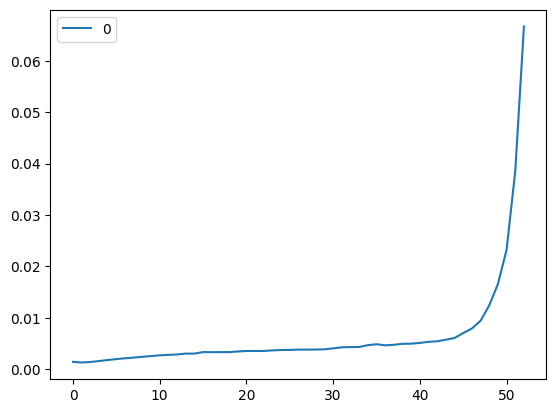

In [305]:
import pandas as pd

pd.DataFrame(torch.sigmoid(example_output).detach().numpy()).T.plot()

In [162]:
pitch_level_tensors['val'][45]['seq'][0][0]

tensor([ 0.0000e+00,  6.0000e+00,  2.2000e+01,  8.7698e-02,  8.7698e-02,
         9.3100e+01, -1.9200e+00,  6.3100e+00,  2.2460e+03])